# caggle 대회 문제 풀이 : 집값 예측 모델 생성하기 

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 가져오기  
        -1. 데이터 조사
        -2. 데이터 열기
        
    2-2. 데이터 전처리  
        -1. 전처리 기획
        -2  전처리
        
    2-3. 모델 학습
        -1. 단일 모델 생성
        -2. 각 모델 최적화(GridSearch)
        -3. Blending
        -4  학습
        
    2-4. 데이터 제출   

### 3. POTG
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


## 1. Ready

### 1-1. 오늘의 Exp 와 Rubric

오늘은 캐글(caggle) 에 있는 과거 대회 문제를 풀어보는 시간을 가지도록 한다.
캐글은 데이터 사이언티스트들을 위한 경진대회 사이트 이다.

<img src="./caggle.PNG"></img>

캐글에서는 2019년 상반기(3월 ~ 4월)  
주어진 데이터만을 가지고 집값을 예측하는 회귀 모델 학습 대회를 열었다.

대회의 1등은 **'ddcddc'의 RMSE Score 28점.**  
그 이하는 다음과 같다. 

<img src="./score.PNG"></img>

우리는 score 110000 점 이하로 떨어뜨려 보도록 하겠다.   
참고로 50위까지 있는데 110000점은 순위권 밖이다..

평가 Rubric 은 다음과 같다.

|평가문항|상세기준|
|---|---|
|캐글 데이터 분석 전과정이 확실한지|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission 까지 완료하였다.|
|전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행됏는지|제출된 노트북이 캐글 커널로 사용될 만큼 전처리,학습,최적화 진행과정이 체계적으로 기술되었다.|
|회귀모델 예측정확도가 기준 이상인지|피쳐 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 leaderboard 의 Private score 기준 110000 이하의 점수를 얻었다.|

### 1-2. 사용하는 라이브러리

In [36]:
import os
from os.path import join
#데이터 경로 설정 라이브러리

import pandas as pd
import numpy as np
#데이터 배열 형성 라이브러리

import missingno as msno 
#결측치 시각화 확인 라이브러리

import matplotlib.pyplot as plt
import seaborn as sns 
# 자료 시각화 라이브러리


from sklearn.model_selection import train_test_split
#train test 분리 라이브러리

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# 모델 라이브러리

from sklearn.model_selection import KFold, cross_val_score
#모델 성능 평가 라이브러리

from sklearn.metrics import mean_squared_error
#모델 평가기준 MSE 라이브러리

from sklearn.model_selection import GridSearchCV
#하이퍼 파라미터 수정 라이브러리


## 2. GAME
### 2-1. 데이터 가져오기

#### 2-1-1. 데이터 조사하기

캐글 대회 페이지에 자료가 준비되어 있다.  
자료는 세 가지로 다음과 같다.  
- train.csv
- test.csv
- sample_submission.csv

#### trian 데이터에는 총 21가지의 데이터가 있다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 :15 이웃의의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 15 이웃의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### test 데이터에는 3. price 데이터를 제외한 20개의 데이터가 있다.

#### sample 데이터는 제출형태를 보여주는 예시 파일이다.  
ID 와 predict_price 를 DataFrame 형태로 가지고 있다.

#### 2-1-2. 데이터 읽어보기

데이터를 다운로드 한 다음, os 라이브러리와 pandas 라이브러리를 사용해 파일을 열람할 수 있다.

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/workplace/[E-05]/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [3]:
print('train data dim : {}'.format(data.shape))

data.head()

train data dim : (15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
print('sub data dim : {}'.format(sub.shape))

sub.head()

sub data dim : (6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


train 데이터는 약 15000개의 행으로 이루어져 있으며,  
이를 통해 약 6000개의 집값을 예측해 submission 하면 된다. 

### 현재
data = train 데이터의 DF 형태  
sub = price를 예측하여 제출할 데이터 DF 형태

---

### 2-2. 데이터 전처리

#### 2-2-1. 전처리 기획

차분하게 생각해보자. 
우리가 예측하려는 값은 price 기 때문에  
**1. 라벨링을 위해 train_y 데이터로 price 값만 따로 떼어야 한다.**  

그 다음, 가지고 있는 sub 데이터와 합쳐서  
**2. 20개의 각 속성에 유의미한 패턴이 있는지 탐구한다.**  

    - 여기서 결측치 / 무의미한 데이터 / 더 나은 판단을 위한 정규화
    를 진행한다.

또한 우리는 sub 에 대한 결과 데이터가 없기 때문에  
**3. train 데이터에서 다시 train 과 test를 나누어 모델 평가를 한 다음 sub 데이터를 예측해야 한다.**



#### 2-2-2. 전처리

In [5]:
# 1. price 분리

y = data['price']
del data['price']

# sub과 합쳐 유의미한 패턴 확인

train_len = len(data)
data_all = pd.concat((data, sub), axis=0)

- 결측치 확인

id의 결측치 갯수 : 0
date의 결측치 갯수 : 0
bedrooms의 결측치 갯수 : 0
bathrooms의 결측치 갯수 : 0
sqft_living의 결측치 갯수 : 0
sqft_lot의 결측치 갯수 : 0
floors의 결측치 갯수 : 0
waterfront의 결측치 갯수 : 0
view의 결측치 갯수 : 0
condition의 결측치 갯수 : 0
grade의 결측치 갯수 : 0
sqft_above의 결측치 갯수 : 0
sqft_basement의 결측치 갯수 : 0
yr_built의 결측치 갯수 : 0
yr_renovated의 결측치 갯수 : 0
zipcode의 결측치 갯수 : 0
lat의 결측치 갯수 : 0
long의 결측치 갯수 : 0
sqft_living15의 결측치 갯수 : 0
sqft_lot15의 결측치 갯수 : 0


<AxesSubplot:>

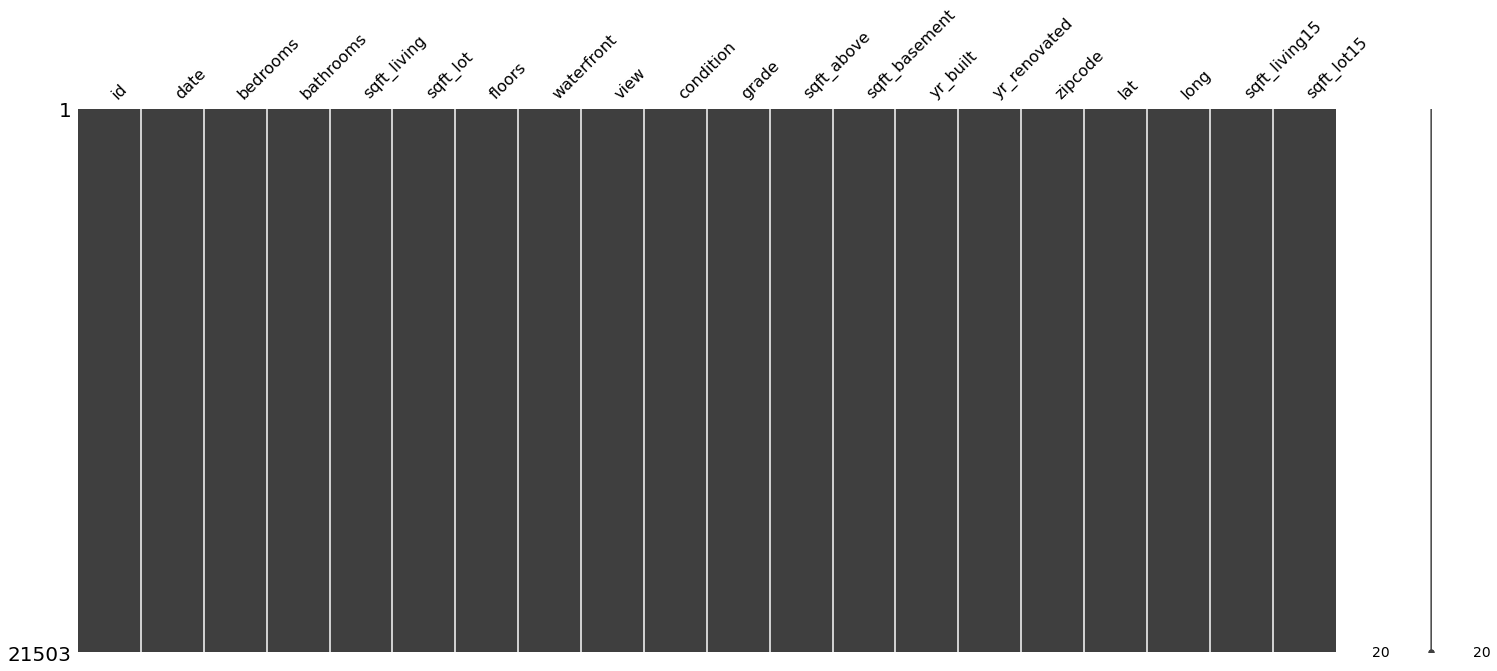

In [6]:
for col in data_all.columns:
    print('{}의 결측치 갯수 : {}'.format(col, len(data_all.loc[pd.isnull(data_all[col]), col].values)))
    

msno.matrix(data_all)

결측치 없음!

- 무의미한 데이터 확인

In [7]:
data_all.head(1)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650


의미라는 것은 내 주관적인 개입이 들어간다.
내가 생각하기에!

- **id 값은 무의미하다.**
- 집을 구매한 날짜가 **(다만 년도 까지로 끊어야 차이가 확실할 것 같다.)** 최신일 수록 비쌀 것이다.
- 침대 개수가 많을 수록 비쌀 것이다.
- 화장실 개수가 많을 수록 비쌀 것이다.
- 평방 피트가 넓을 수록 비쌀 것이다.
- 부지 피트가 넓을 수록 비쌀 것이다.
- 층수가 많을 수록 비쌀 것이다.
- 전방 리버뷰가 있으면 비쌀 것이다.
- view 가 좋으면 비쌀 것이다.
- condition 이 좋으면 비쌀 것이다.
- 표준 grade가 높으면 비쌀 것이다.
- 지하실 제외 피트가 넓으면 비쌀 것이다.
- 지하실이 넓으면 비쌀 것이다.
- 집을 지은 년도가 최신일 수록 비쌀 것이다.
- 집을 재건축한 년도가 최신일 수록 비쌀 것이다
- **우편번호는 무의미하다**
- 위도와 경도의 어떤 패턴은 집을 비싸게 만들 것이다.
- 15 이웃들의 집이 상대적으로 좋지 않을 수록 비쌀 것이다.




---
#### 따라서
1. id값을 제거하기 
2. 년도 값을 수정하기
2. 우편번호 제거하기

In [8]:
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:4])).astype(int)

del data['zipcode']

더 유의미한 정보를 찾기 위해 나머지 자료들의 분포를  
matplot 라이브러리로 시각화해보았다.

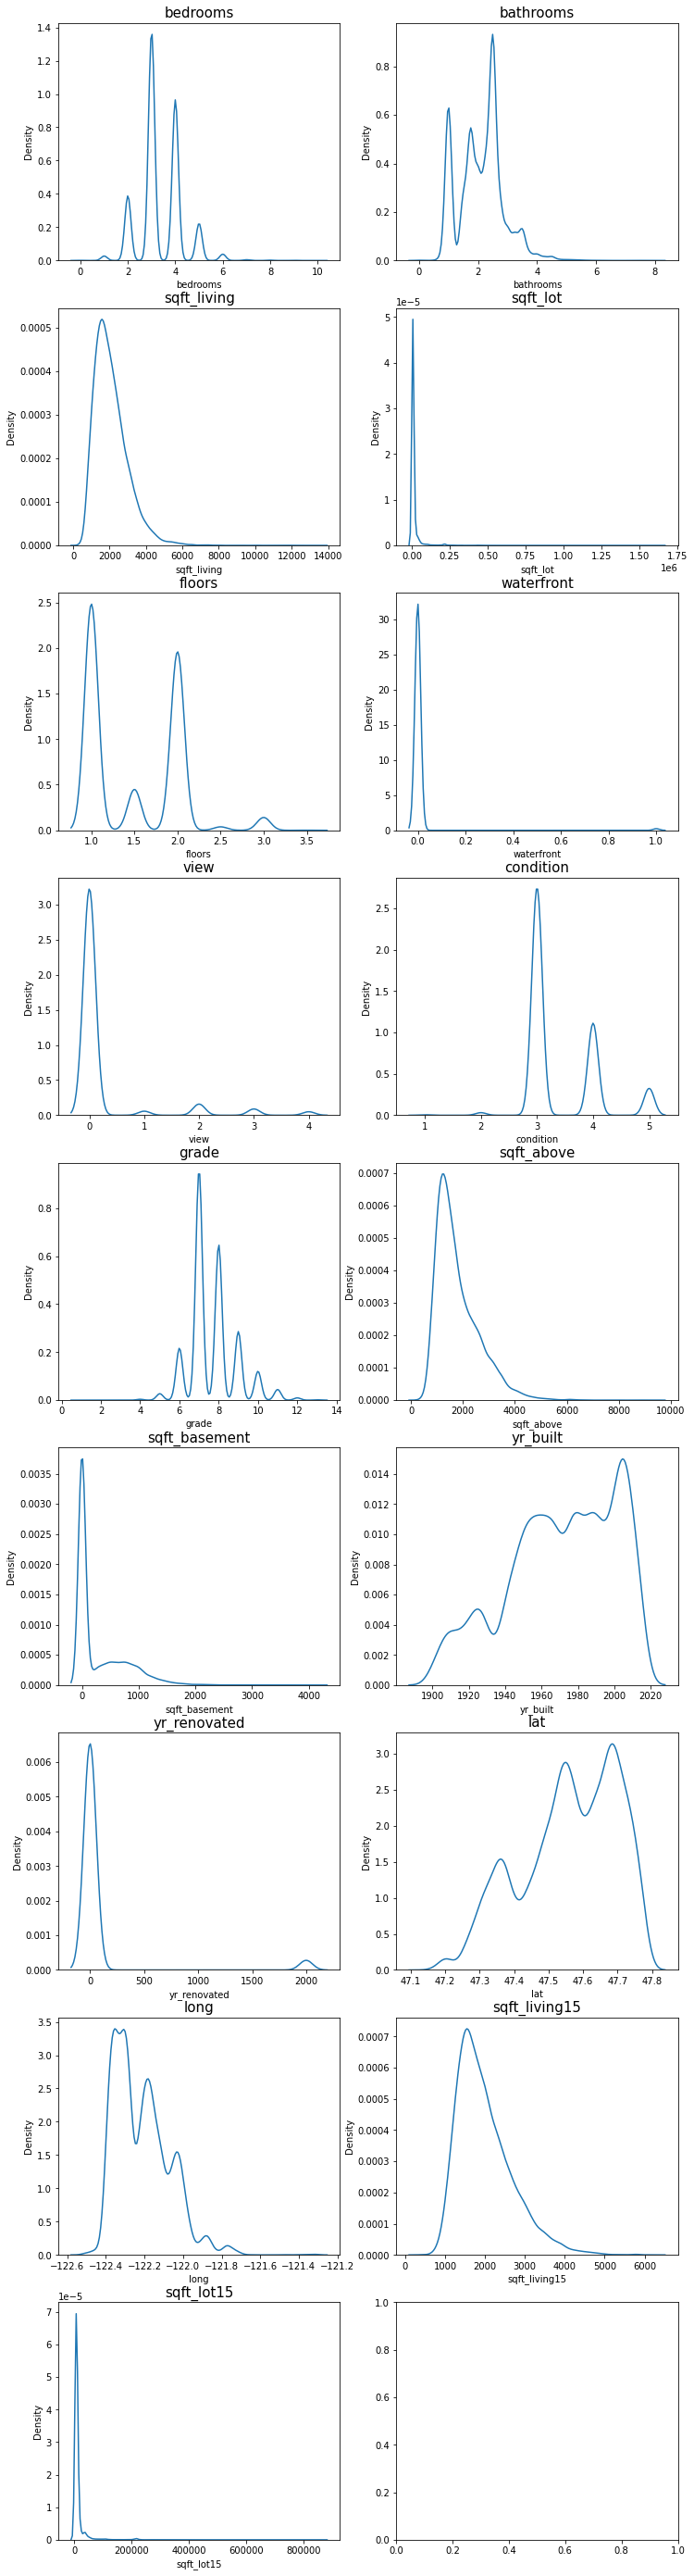

In [9]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

Text(0.5, 1.0, 'price')

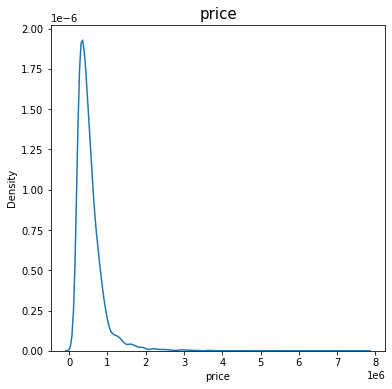

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

sns.kdeplot(data=y)
ax.set_title(y.name, fontsize=15)


그리고 일정 데이터가 범주형 데이터인 것을 확인할 수 있다.

- bedrooms
- bathrooms
- floors
- waterfront
- view 
- condition
- grade

그렇다면 이 자료들은 막대로 보는게 더 맞지 않을까?
 

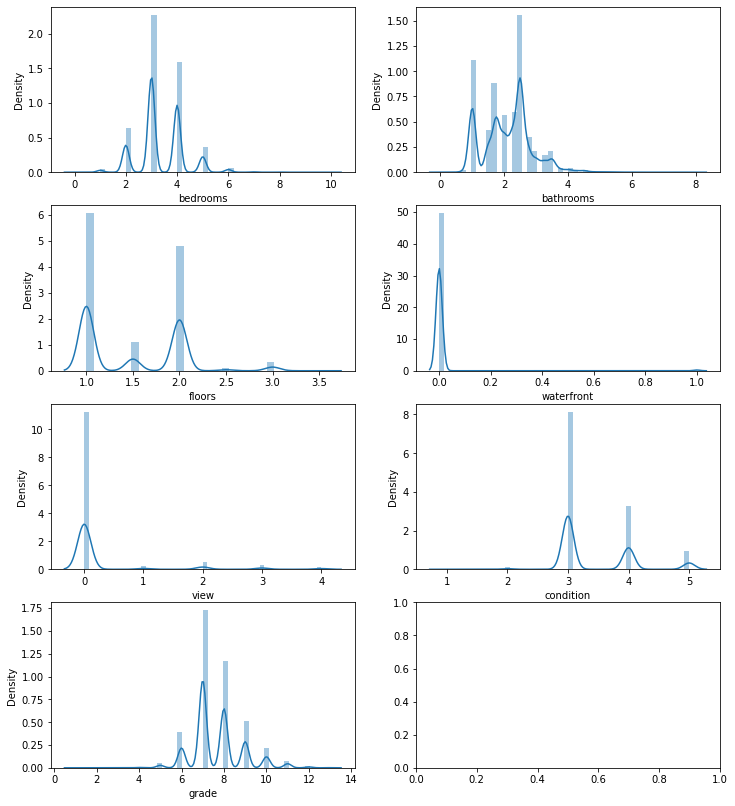

In [11]:
categorial_columns = [ 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

fig, ax = plt.subplots(4, 2, figsize=(12, 14)) 

count = 0
for row in range(4):
    for col in range(2):
        sns.distplot(data[categorial_columns[count]], ax=ax[row][col])
        count += 1
        if count == 7 :
            break

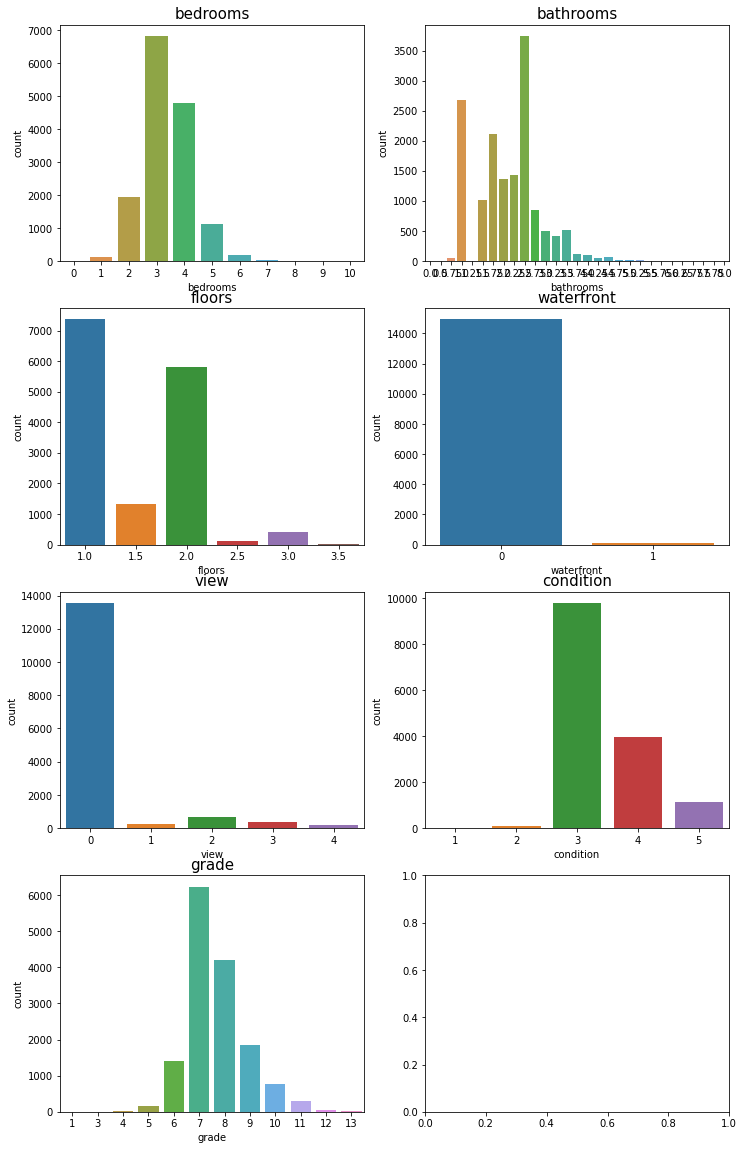

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20)) 

count = 0
for row in range(4):
    for col in range(2):
        sns.countplot(data[categorial_columns[count]],x=data[categorial_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(categorial_columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

또한 basement 그래프를 보면
생각보다 지하실이 없는 집을 확인할 수 있다.

<img src="./base.PNG"></img>

이를 통해 **지하실이 있냐 없냐에 대한 속성** 을 추가해 줘도 좋을 것 같다.

In [83]:

data['sqft_total_size'] = data['sqft_above'] + data['sqft_basement']
data['sqft_ratio_1'] = data['sqft_living'] / data['sqft_total_size']

renobate의 값도 마찬가지이다.  
수리를 한 집과 안한 집의 편차가 크니 이것도 **수리를 했냐 안했냐에 따라 구별**하는 것이 좋겠다.

In [88]:
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
data['renovated'] = data['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
data['yr_renovated'] = data['yr_renovated'].fillna(data['yr_built'])
data['renovated'] = data['renovated'].fillna(0)
data['yr_renovated'] = data['yr_renovated'].astype('int')

일정 데이터들이 좌편향 된 것도 확인할 수 있다.
- sqft_lot
- sqft_above
- sqft_basement
- sqft_lot105
- price  

이것을 더욱 정확하게 평가하기 위해 정규분포로 정규화시켜줄 수 있다.



In [13]:
skew_columns = [ 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [14]:
y = np.log1p(y)

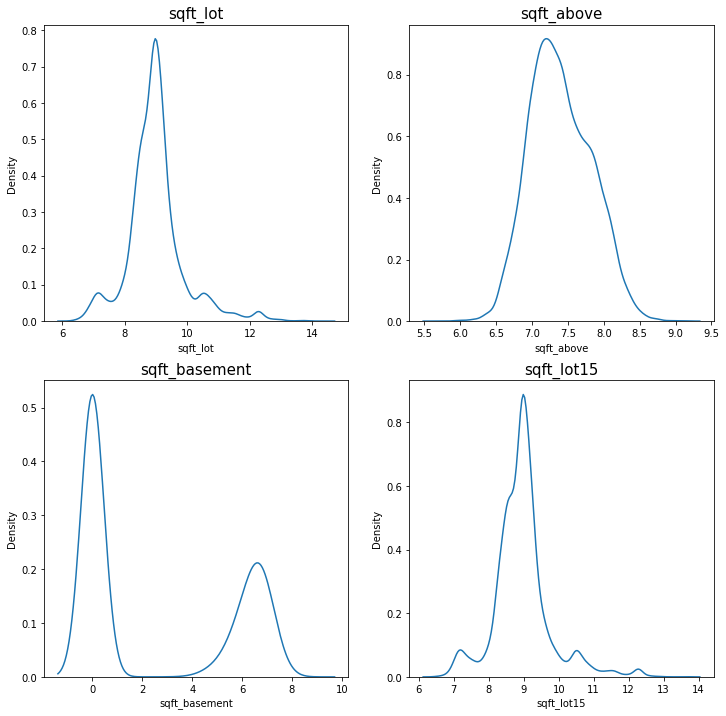

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

count = 0
for row in range(2):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 4 :
            break

<AxesSubplot:xlabel='price', ylabel='Density'>

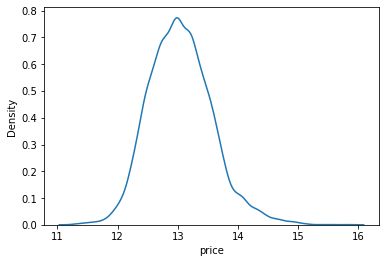

In [16]:
sns.kdeplot(data=y)

최종적으로 학습을 할 수 있도록 train 데이터와 test 데이터를 분리 해준다.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=2020, test_size=0.2)


### 현재 상태

1. data, y 에서

- id값 제거
- 년도 값을 수정
- 우편번호 제거
- binary 데이터 생성 (지하실, 재건축)
- 편향 데이터 4종 정규화

2. train / test 데이터 분리하여 각 변수에 저장


## 동일한 패턴으로 sub 데이터도 전처리를 거친다

In [ ]:
del sub['id']

sub['date'] = sub['date'].apply(lambda x : str(x[:4])).astype(int)

del sub['zipcode']

sub['sqft_total_size'] = sub['sqft_above'] + sub['sqft_basement']
sub['sqft_ratio_1'] = sub['sqft_living'] / sub['sqft_total_size']

skew_columns = [ 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']


for c in skew_columns:
    sub[c] = np.log1p(sub[c].values)

In [89]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_total_size,sqft_ratio_1,renovated
0,2014,3,1.00,1180,8.639588,1.0,0,0,3,7,...,0.000000,1955,1955,47.5112,-122.257,1340,8.639588,7.074117,166.805275,0.0
1,2015,2,1.00,770,9.210440,1.0,0,0,3,6,...,0.000000,1933,1933,47.7379,-122.233,2720,8.995041,6.647688,115.829738,0.0
2,2015,3,2.00,1680,8.997271,1.0,0,0,3,8,...,0.000000,1987,1987,47.6168,-122.045,1800,8.923191,7.427144,226.197307,0.0
3,2014,3,2.25,1715,8.827615,2.0,0,0,3,7,...,0.000000,1995,1995,47.3097,-122.327,2238,8.827615,7.447751,230.270848,0.0
4,2015,3,1.50,1060,9.181118,1.0,0,0,3,7,...,0.000000,1963,1963,47.4095,-122.315,1650,9.181118,6.966967,152.146548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,2014,4,2.50,2520,8.703507,2.0,0,0,3,9,...,0.000000,2014,2014,47.5137,-122.167,2520,8.703507,7.832411,321.740014,0.0
15031,2015,4,3.50,3510,8.881975,2.0,0,0,3,9,...,6.814543,2009,2009,47.5537,-122.398,2050,8.732466,14.678194,239.130234,0.0
15032,2014,3,2.50,1530,7.031741,3.0,0,0,3,8,...,0.000000,2009,2009,47.6993,-122.346,1530,7.319865,7.333676,208.626604,0.0
15033,2015,4,2.50,2310,8.668024,2.0,0,0,3,8,...,0.000000,2014,2014,47.5107,-122.362,1830,8.881975,7.745436,298.240166,0.0


---

### 2-3. 모델 학습 

### 2-3-1 단일 모델 생성

In [19]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]



In [20]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


해당 함수는 저희가 예측한 y_pred 값과 실제 y_test 값을 지수화(로그를 풀어줌) 하고,  
그 값을 바탕으로 MSE 값을 구하고,  
MSE 값에 루트를 씌워 RMSE 값을 구한다.


In [24]:
def get_scores(models, X_train, X_test, y_train, y_test):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, X_train, X_test, y_train, y_test)

,RMSE
GradientBoostingRegressor,129505.156644
RandomForestRegressor,125293.912358
LGBMRegressor,111440.121134
XGBRegressor,111309.678813


해당 함수는 저희가 준비한 네 가지의 모델로 각각 학습하여  
결과로 나온 RMSE 값을 보여준다. 

RMSE 는 평균 오차의 값으로서 작을 수록 오차가 적다.



이렇게만 보면 값이 너무 크기 때문에 이것이 좋은 모델인지 알 수가 없다.

그래서 우리는 교차검증기법을 통해 모델의 성능을 평가할 수 있다.



In [44]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

In [45]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(data)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=data, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.8773
Model: XGBoost, CV score:0.8943
Model: LightGBM, CV score:0.9006
Model: RandomForest, CV score:0.8834


해당 함수는 CV(교차검증) 점수인 R square 점수를 보여준다.  
이 값은 1에 가까울 수록 모델이 잘 학습되었다는 것을 나타낸다.

### 2-3-3. 모델 최적화 (GridSearch)

각 모델들의 성능을 최적화 하기 위해 하이퍼 파라미터를 가장 좋은 녀석으로 바꿔준다.


In [51]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(data, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

우리가 수정할 파라미터를 두개씩 두 부분에 넣었으니,  
우리가 시도해 볼 수 있는 방법은 총 4가지이다.

이것에 대한 정보를 열람할 수 있다.

In [52]:
grid_model.cv_results_

{'mean_fit_time': array([0.12678304, 0.21707907, 0.42768955, 0.55824761]),
 'std_fit_time': array([0.02113436, 0.07304015, 0.15002283, 0.05066449]),
 'mean_score_time': array([0.00897193, 0.01282449, 0.04019771, 0.02758374]),
 'std_score_time': array([0.00385294, 0.00337981, 0.02030496, 0.0033845 ]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02952655, -0.02745722]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03088055, -0.02859389]),
 'split2_test_score': array([-0.07354904

우리가 필요한 정보는
어떤 하이퍼 파라미터 상태가 가장 좋은 예측값을 보이는 지 이다.

그것을 위해선 파라미터에 따른 오차를 확인하면 된다.

다음은 해당 과정을 한번에 수행하는 함수이다.

In [56]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027613,0.166171
2,10,50,-0.029820,0.172684
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END ...................

결과적으로 max_depth 10, n_estimators 100 이 가장 좋은 확률을 보여주고 있다.

In [57]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
    'min_samples_split': [2, 20],
    'max_depth': [3, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,min_samples_split,score,RMSLE
3,10,20,-0.029117,0.170637
2,10,2,-0.030198,0.173776
0,3,2,-0.034061,0.184556
1,3,20,-0.034120,0.184716


[CV] END ...................max_depth=3, min_samples_split=2; total time=   4.6s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   4.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  15.0s
[CV] END .................max_depth=10, min_samples_split=20; total time=  17.7s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   6.9s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   4.8s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  17.4s
[CV] END .................max_depth=10, min_samples_split=20; total time=  16.9s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.8s
[CV] END ..................max_depth=3, min_samples_split=20; total time=   7.9s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  15.0s
[CV] END .................max_depth=10, min_samples_split=20; total time=  17.1s
[CV] END ...................

 GradientBoostingRegressor 해당 모델은 각각 10, 20 이 가장 높은 예측값을 보여준다.
 
 이어서 더 많은 시도를 해보았고, 각 모델의
 하이퍼 파라미터를 조사하고 더 다양한 값을 넣어 돌려보았다.
 
 그래서 최종적을 나온 파라미터 값들은 다음과 같다.
 
GradientBoostingRegressor  
(n_estimators=200, min_samples_split=8, min_samples_leaf=2)  

LGBMRegressor  
(max_depth=32, n_estimators=100, min_data_in_leaf=1, num_leaves=90)  

RandomForestRegressor  
(max_depth=4, n_estimators=100, min_samples_split=256, min_samples_leaf=2)  

### 2-3-3. Blending

우리는 학습한 3개의 모델을 섞어  
세 가지 모델의 예측값의 평균을 가져올 것이다.

In [79]:
random_state=2020 

gboost = GradientBoostingRegressor( n_estimators=200, min_samples_split=8, min_samples_leaf=2, random_state=random_state)
lightgbm = LGBMRegressor(max_depth=32, n_estimators=100, min_data_in_leaf=1, num_leaves=90, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=4, n_estimators=100, min_samples_split=256, min_samples_leaf=2, random_state=random_state)

good_models = [{'model':gboost, 'name':'GradientBoosting'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]


def AveragingBlending(models, data, y, sub):
    for m in models : 
        m['model'].fit(data, y)
    
    predictions = np.column_stack([
        np.expm1(m['model'].predict(sub)) for m in models
    ])
    return np.mean(predictions, axis=1)

### 2-3-4. 학습

In [80]:
y_pred = AveragingBlending(models, data, y, sub)
print(len(y_pred))
y_pred

6468


array([ 512836.85352272,  456152.7851734 , 1366996.90148971, ...,
        464313.58545316,  329866.5062625 ,  456386.81695446])

### 2-4. 데이터 제출  

In [81]:
data_dir = os.getenv('HOME')+'/aiffel/workplace/[E-05]/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


price 값이 비어있는 submission 파일에 우릭 예측한 y_pred 값을 넣어주자.

In [82]:
submission['price'] = y_pred
submission


,id,price
0,15035,5.128369e+05
1,15036,4.561528e+05
2,15037,1.366997e+06
3,15038,2.990311e+05
4,15039,3.173153e+05
...,...,...
6463,21498,2.373915e+05
6464,21499,4.317221e+05
6465,21500,4.643136e+05
6466,21501,3.298665e+05


In [75]:
submission_csv_path = '{}/submission_blending3.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/workplace/[E-05]/kaggle_kakr_housing/data/submission_blending3.csv


다운로드를 완료했다면 해당 경로에 들어가 csv 파일을 다음의 위치에 업로드한다.

[제출 링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/submit)

제출 후에는 'my Submission' 항목에서 본인의 점수를 확인할 수 있다.

<img src="./score2.PNG"></img>

private 108466점이 나왔다!

## 3. POTG
### 3-1. 소감(POTG)  

#### "🩹 마음의 상처를 받았습니다,, 그냥 노숙할게요 집 값 알아내기 너무 힘들어요"  
전반적으로 데이터 전처리 / 모델링  두가지를 스스로 판단하는 첫번째 프로젝트였습니다.  
특히 주어진 데이터만으로는 점수를 내기가 너무 어려워 의미있는 새 데이터를 만들기 위해    
많은 자료를 찾아봤고 적절한 하이퍼 파라미터를 찾는데 너무나 많은 시간이 걸렸습니다.  

### 3-2. 어려웠던 점과 극복방안 

#### 🙄결측치를 찾기 위한 함수  
pd.isnull(data['열의 이름'])  
해당 열에 NaN 값이 있다면 True 로 반환하는 Series 객체 반환

결측치 데이터의 값을 가져오는 함수
data.loc[Series객체, '열의 이름']
True 값의 데이터를 리스트의 묶음으로 반환하는 Series 객체 반환  

data.loc[Series객체, '열의 이름'].values  
Series객체에서 데이터값만을 가져오는 리스트 객체 반환  

그래서 결측치의 개수를 알고 싶다면 이 두 메서드를 합쳐서  
len(data.loc[pd.isnull(data['열이름']), '열의 이름'].value)  

를 사용하면 됩니다.

#### 🙄범주형 숫자 데이터도 변환을 해주어야 하는가?
데이터를 고르다가
침대수가 많다 - 비싸다  
처럼 단순 비례형인 관계도 있지만

특정 경도 위도에 위치해 있다 - 비싸다

는 다른 방식으로 구현해야 하지 않을까 싶었다.
하지만 별다른 조치를 취하지 못했습니다.

다만 지하실 같은 경우는 지하실이 있고 없음의 차가 크다고 생각하여
지하실의 유무로 0과 1을 반환하는  새로운 데이터 columns를 만들었습니다.


#### 🙄시각화 라이브러리 matplot의 이용  
집값을 유추하기 위한 속성들에게서 의미를 찾아낼때  
사람인 우리는 시각적인 요소로 판단하는것이 best 입니다.  
그때 쓰는 것이 matplot 인데, 해당 라이브러리에서는   
다양한 그래프 표현 메서드를 가지고 있습니다. 

이것을 조사하고 사용하는 것에 시간이 많이 걸렸지만.  
그 만큼 범주형과 연속형에 대해 적절한 그래프를 사용하여
분석에 용이하게 했습니다.

#### 🙄모델 학습 시 데이터 타입의 정형화

데이터 구성 후 학습을 했는데

---
ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.date
                
---
                
                
라는 오류가 떴습니다. 무슨 이유인지 살펴보니


<img src="./object.PNG"></img>

이처럼 data 형식이 정수형이 아닌 object 형 자료였습니다.

그래서  
data['date'] = data['date'].apply(lambda x : str(x[:4]))  
코드 부분에 **.astype(int)** 를 통해 자료형을 정수형으로 변환해 넣어주었다


#### 🙄예측할 sub 데이터의 데이터 전처리

난 모델을 학습시키기 위해 train 데이터만 전처리하면 될 것이라 생각했는데   
결국 예측을 하기 위해선 동일한 데이터 전처리를 거친 test 데이터 셋이 필요했습니다.  

그래서 똑같은 데이터 전처리를 두번이나 했습니다.  

처음에 데이터의 사용태를 확실하게 기획하고 가야 합니다!  

#### 🙄 log1p 를 쓰는 이유
그냥 평범하게 log 화를 하지 않고 1을 더한 후 log 를 하는 log1 메서드를 사용하는지가 궁금했습니다.
그 이유는 price 중 0의 값이 있다면 log0 이 되어 값이 나오지 않기 때문이라고 합니다.
때문에 복원할 때에도 exp 가 아닌 exp1 을 사용합니다.

### 3-3. 추후  

아무래도 metplot 시각화 라이브러리가 EDA 에 있어서 많은 vision을 제공해줍니다.
또한 프로젝트 도중에 알게 된 .value_counts() 메서드도 데이터를 손쉽게 판단할 수 있게 해줍니다.

모델의 파라미터를 아무리 바꿔도
더 정제되고 더 값어치 있는 데이터를 하나라도 늘여 사용하는 것이 확실히 차이가 난다고 느낍니다.

EDA (Explotary Data Analysis) 능력을 키워야겠다고 다짐했습니다.
